# Unsupervised Deep Learning for Model-Free BBB Leakage Detection with DCE-MRI in Diffuse Gliomas

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import nibabel
import time

### Data loading

In [2]:
root_folder = "../data/DCE_tumor_new/Train/" # root folder
folders = os.listdir(root_folder)

Nx = 192
Ny = 192
Nz = 40 # the number of slices
Nt = 60 # the number of frames
N_baseline = 3 # the number of baseline signals

i = 0
for folder in range(len(folders)):

    # load mask: [Nx x Ny x Nz]
    tumor_mask = torch.from_numpy(nibabel.load(root_folder + folders[folder] + "/tumor_mask.nii.gz").get_fdata()).to(torch.float) # tumor mask
    tumor_mask[tumor_mask > 0] = 1
    dce_mask = torch.from_numpy(nibabel.load(root_folder + folders[folder] + "/dce_mask.nii.gz").get_fdata()).to(torch.float) # brain mask
    
    # load dce: [Nx x Ny x Nz x Nt]
    raw_dce = torch.from_numpy(nibabel.load(root_folder + folders[folder] + "/dce.nii.gz").get_fdata()).to(torch.float)

    # exclude tumor slices
    raw_dce = raw_dce[:, :, torch.where(tumor_mask.reshape(-1, Nz).sum(0) == 0)[0]]
    dce_mask = dce_mask[:, :, torch.where(tumor_mask.reshape(-1, Nz).sum(0) == 0)[0]]
    raw_dce *= dce_mask.unsqueeze(3)

    # save tensor
    temp = raw_dce
    i += 1
    if i == 1:
        sortdce = temp
    else:
        sortdce = torch.cat((sortdce, temp), 2)

### Preprocessing of DCE data

In [3]:
# flatten and remove garbage signals
forflat = sortdce*(sortdce.mean(3) > 20).unsqueeze(3)
flatmask = forflat[:, :, :, 0] > 0
dce = forflat[flatmask]

# transform to signal enhancement ratio
SI0 = dce[:, :N_baseline].mean(1).unsqueeze(1)
dce -= SI0
dce /= SI0
dce = dce[((dce.max(1)[0]) < 15)] # clipping

### Normalization and context preservation

In [4]:
box = 4 # width of refernce signal
dce_box = torch.ones(dce.shape[0], Nt + box)
dce_box[:, :Nt] = (dce - dce.min(1)[0].unsqueeze(1)) / 15
dce_box[:, :N_baseline] = 0

### Training of autoencoder

[Epoch:    1] cost = 0.0132075343


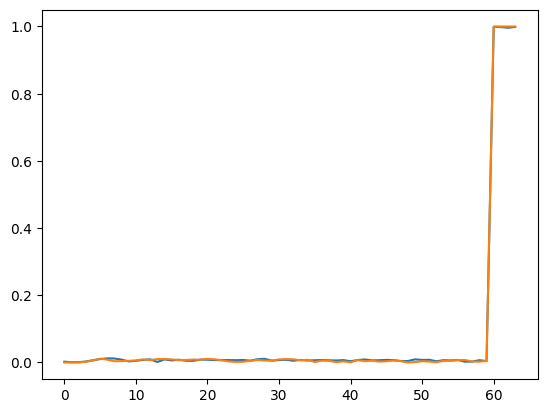

[Epoch:    2] cost = 0.00867610425


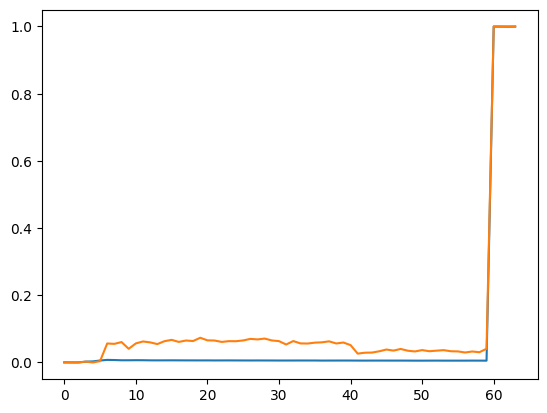

[Epoch:    3] cost = 0.00280754664


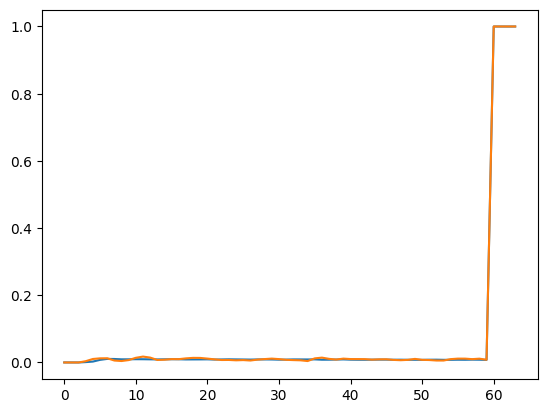

[Epoch:    4] cost = 0.00332162855


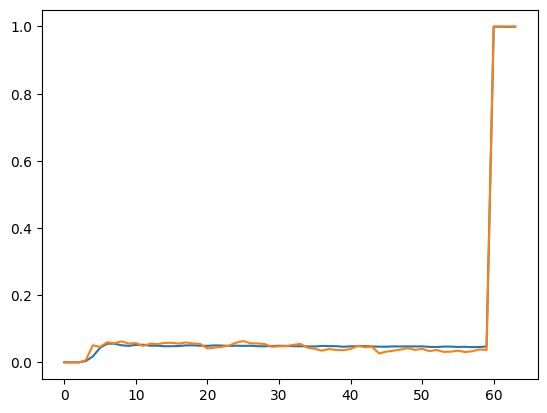

[Epoch:    5] cost = 0.00257915375


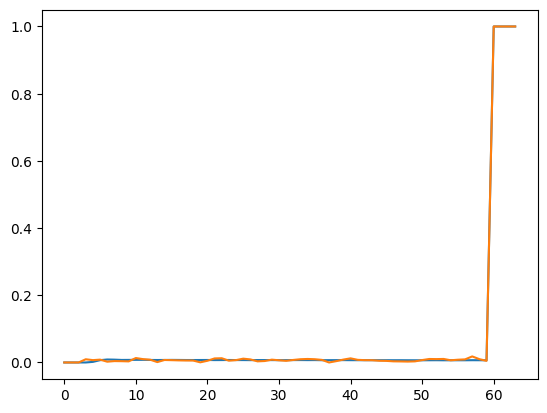

[Epoch:    6] cost = 0.00272119208


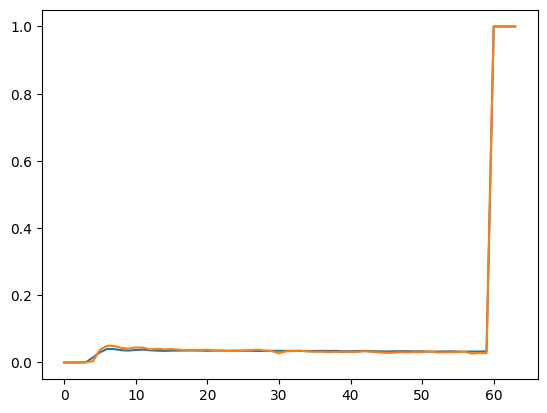

[Epoch:    7] cost = 0.00309000025


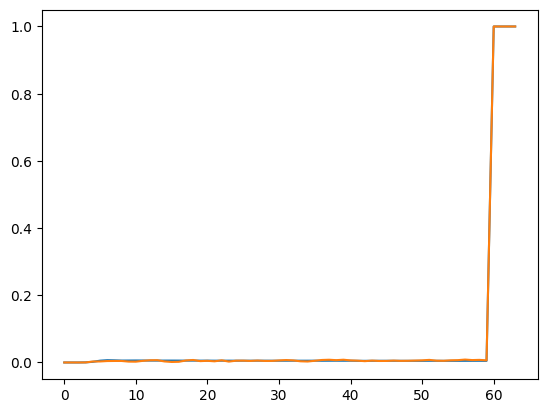

[Epoch:    8] cost = 0.00269185891


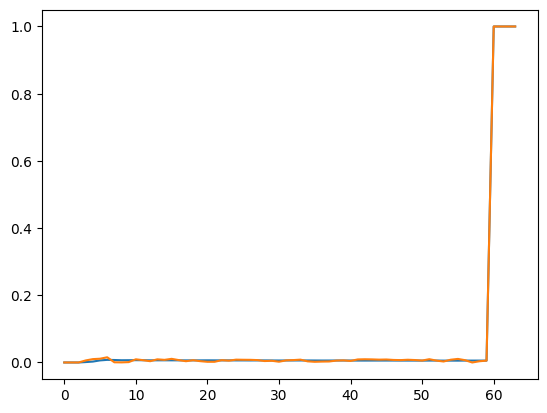

[Epoch:    9] cost = 0.00290136971


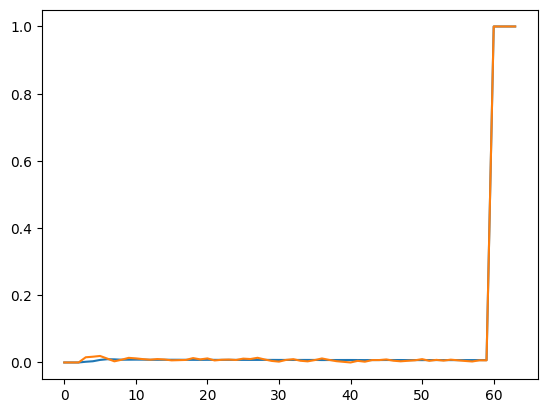

[Epoch:   10] cost = 0.00310511468


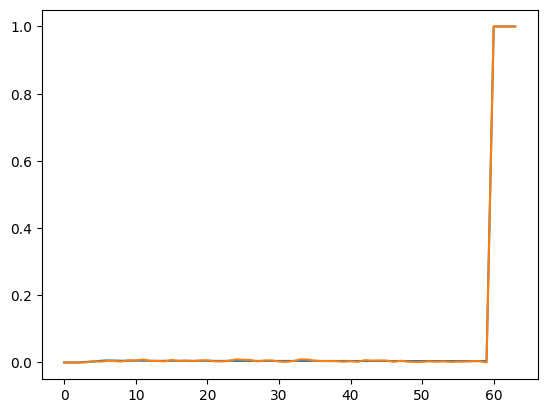

In [5]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(nn.Linear(Nt + box, 32),
                                    nn.LeakyReLU(),
                                    nn.Linear(32, 16),
                                    nn.LeakyReLU(),
                                    nn.Linear(16, 8),
                                    nn.LeakyReLU()
                                    )

        self.dec = nn.Sequential(nn.Linear(8, 16),
                                    nn.LeakyReLU(),
                                    nn.Linear(16, 32),
                                    nn.LeakyReLU(),
                                    nn.Linear(32, Nt + box),
                                    nn.Sigmoid()
                                    )
    
    def forward(self, x):
        out = self.enc(x)
        out = self.dec(out)
        return out
    
# learning rate and batch size
lr = 1e-4
batch_size = 512

encoder = AE().to('cuda')
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
ds_train_AE = TensorDataset(dce_box.to('cuda'), dce_box.to('cuda'))
loader_train_AE = DataLoader(ds_train_AE, batch_size = batch_size, shuffle = True)
lossfcn = torch.nn.L1Loss()

# train
encoder.train()
for epoch in range(10):
    for X, Y in loader_train_AE:
        x_enc = encoder.enc(X)
        x_reconst = encoder.dec(x_enc)
        loss = lossfcn(x_reconst, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # plot
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, loss))
    plt.plot(x_reconst.data.cpu()[0])
    plt.plot(X.data.cpu()[0])
    plt.show()
encoder.eval()

#%% save
torch.save(encoder.state_dict(), "./encoder_box")

### Inference

In [6]:
root = "./Test/"
# folders = [os.listdir(root)[0]] # for all patients
folders = [os.listdir(root)[0]] # for specific patient

with torch.no_grad():
    for patientID in folders:
        tumor_mask = torch.from_numpy(nibabel.load(root + patientID + "/tumor_mask.nii.gz").get_fdata()).to(torch.float) # load tumor mask
        raw_dce = torch.from_numpy(nibabel.load(root + patientID + "/dce.nii.gz").get_fdata()).to(torch.float) # load dce
        dce_mask = torch.from_numpy(nibabel.load(root + patientID + "/dce_mask.nii.gz").get_fdata()).to(torch.float) # load brain mask
        ktrans = torch.from_numpy(nibabel.load(root + patientID + "/ktrans_aif.nii").get_fdata()).to(torch.float) # load ktrans

        # preprocessing
        test_invivo = raw_dce.reshape(-1, Nt)
        SI0 = test_invivo[:, :N_baseline].mean(1).unsqueeze(1)
        test_invivo -= SI0
        test_invivo /= SI0

        # inference
        start = time.time()

        test_invivobox = torch.ones(test_invivo.shape[0], Nt + box)
        test_invivobox[:, :Nt] = (test_invivo - test_invivo.min(1)[0].unsqueeze(1)) / 15
        test_invivobox[:, :N_baseline] = 0
        test_invivobox = test_invivobox.cuda()

        recon_test = encoder(test_invivobox)
        img_distance = (test_invivobox - recon_test).squeeze()[:, N_baseline:Nt].mean(1)
        img_distance_abs = (test_invivobox - recon_test).squeeze()[:, N_baseline:Nt].abs().mean(1)
        leakage_notnorm = (img_distance.data.cpu()).reshape(Nx, Ny, Nz)*dce_mask
        leakage_abs_notnorm = (img_distance_abs.data.cpu()).reshape(Nx, Ny, Nz)*dce_mask

        totals = start - time.time()

        print('inference time:', -totals)

        # ktrans
        ktrans_map = ktrans
        ktrans_map[ktrans_map.isnan()] = 0
        ktrans_map *= dce_mask

inference time: 0.15666913986206055


### Plot

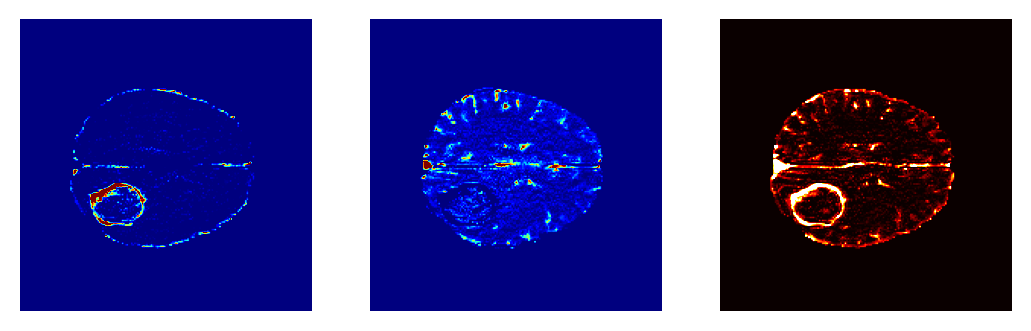

In [7]:
# plot
iz = 24
plt.figure(dpi = 200)
plt.subplot(131)
plt.axis("off")
plt.imshow((leakage_notnorm[:, :, iz]*(leakage_notnorm[:, :, iz] < 0)).abs() * 15 * 100, vmax = 5, cmap = cm.jet)
plt.subplot(132)
plt.axis("off")
plt.imshow((leakage_notnorm[:, :, iz]*(leakage_notnorm[:, :, iz] > 0)).abs() * 15 * 100, vmax = 5, cmap = cm.jet)
plt.subplot(133)
plt.axis("off")
plt.imshow(ktrans_map[:, :, iz].abs(), vmax = 0.25, cmap = cm.hot)
plt.show()